In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# 1 Imports

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import textwrap
from individual import *

In [56]:
# 2 Import Data

(X_train, X_test, y_train, y_test), column_names = load_and_split_data()

In [57]:
# 3 Define Models

rf = RandomForestRegressor(n_estimators=100,
                            n_jobs=-1,
                            random_state=1)

gdbr = GradientBoostingRegressor(learning_rate=0.1,
                                  loss='ls',
                                  n_estimators=100,
                                  random_state=1)

abr = AdaBoostRegressor(DecisionTreeRegressor(),
                         learning_rate=0.1,
                         loss='linear',
                         n_estimators=100,
                         random_state=1)

In [58]:
# 4 Cross Validate

k = 10
cross_val(rf, X_train, y_train, k) 
cross_val(gdbr, X_train, y_train, k) 
cross_val(abr, X_train, y_train, k);

RandomForestRegressor     Train CV | MSE: 9.837 | R2: 0.867
GradientBoostingRegressor Train CV | MSE: 8.679 | R2: 0.883
AdaBoostRegressor         Train CV | MSE: 9.361 | R2: 0.874


In [59]:
# The best model is currently GBR, however the hyperparameters are not tuned - so this situation will
# change after a proper grid-search

In [60]:
# 5 Gradient Boosting with LR = 1

gdbr_lr1 = GradientBoostingRegressor(learning_rate=1.0, loss='ls',
                                     n_estimators=100, random_state=1) 
print("Cross validation score of Gradient Boosting Regressor with lr = 0.1:")
cross_val(gdbr, X_train, y_train, k) 
print("Cross validation score of Gradient Boosting Regressor with lr = 1.0:")
cross_val(gdbr_lr1, X_train, y_train, k);

Cross validation score of Gradient Boosting Regressor with lr = 0.1:
GradientBoostingRegressor Train CV | MSE: 8.679 | R2: 0.883
Cross validation score of Gradient Boosting Regressor with lr = 1.0:
GradientBoostingRegressor Train CV | MSE: 21.850 | R2: 0.718


In [61]:
# A learning rate of 1 has more than doubled MSE, also R2 is worse

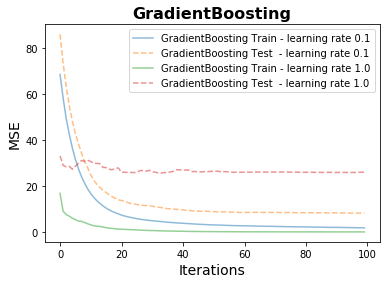

In [62]:
# 6 Investigate effect of the number of iterations

gbr_sm = GradientBoostingRegressor(learning_rate=0.1, loss='ls', n_estimators=100, random_state=1)
gbr_lg = GradientBoostingRegressor(learning_rate=1.0, loss='ls', n_estimators=100, random_state=1)

stage_score_plot(gbr_sm, X_train, y_train, X_test, y_test)
stage_score_plot(gbr_lg, X_train, y_train, X_test, y_test)
plt.legend();
plt.show()

In [63]:
# 7 Investigate effect of learning rate

# See result in previous example

In [64]:
# 8 Explain plot behavior

# For both learning rates the train error drops to near zero with
# progressive boosting stages (iterations).  However, the larger learning
# rate test error doesn't decrease as more iterations are added.  The larger
# learning rate makes large changes per iteration and so likely overfits
# the data.  For the lower learning rate model to get low test error, many
# boosting stages are required.

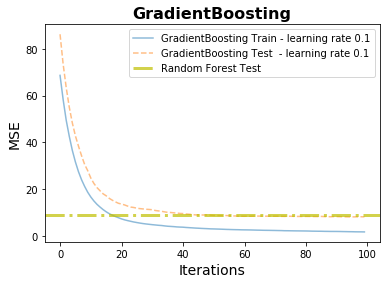

In [65]:
# 9 Compare the Gradient Boosting Regressor with lr = 0.1 to a Random Forest Regressor

stage_score_plot(gdbr, X_train, y_train, X_test, y_test)
rf_score_plot(rf, X_train, y_train, X_test, y_test)
plt.legend();

In [66]:
# Gradient Boost outperforms Random Forest at about 60 iterations.

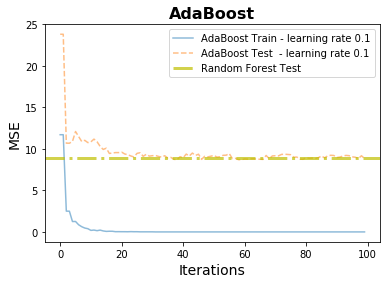

In [67]:
# 10 Compare Adaboost Regressor with lr = 0.1 to the Random Forest Regressor

stage_score_plot(abr, X_train, y_train, X_test, y_test)
rf_score_plot(rf, X_train, y_train, X_test, y_test)
plt.legend();

In [68]:
# With the current hyperparameters, Adaboost performs erratically.
# With very few iterations it outperforms Random Forest

In [69]:
# 11 Grid Search Random Forest

random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20, 40, 80],
                      'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
rf_gridsearch.fit(X_train, y_train)

print( "best parameters:", rf_gridsearch.best_params_ )

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:    4.3s


best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40, 'random_state': 1}


[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:    8.0s finished


In [72]:
# mse for grid searched random forest
mean_squared_error(y_test, best_rf_model.predict(X_test))

8.740998774509805

In [73]:
# mse for default random forest
mean_squared_error(y_test, rf.predict(X_test))

8.945236166666664

In [74]:
# grid search is better

In [75]:
# 12 Grid Search Gradient Boosting


gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'max_features': [1.0, 0.3, 0.1],
                          'n_estimators': [500],
                          'random_state': [1]}


gbr_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                             gradient_boosting_grid,
                             verbose=True,
                             scoring='neg_mean_squared_error')
gbr_gridsearch.fit(X_train, y_train)

print( "best parameters:", gbr_gridsearch.best_params_ )

best_gbr_model = gbr_gridsearch.best_estimator_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:   54.7s finished


best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_state': 1}


In [76]:
# mse for grid searched gbr
mean_squared_error(y_test, best_gbr_model.predict(X_test))

8.166498387403717

In [77]:
# mse for default gbr
mean_squared_error(y_test, gdbr.predict(X_test))

8.221228849448858

In [78]:
# grid searched gradient boosted regressor FTW!